In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, plot_confusion_matrix, classification_report

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import *
%matplotlib inline  
import numpy as np

In [3]:
raw_df = pd.read_csv('CW1_data_202223.csv')
raw_df.head()

,id,Gender,Age,HasDrivingLicense,RegionID,Switch,VehicleAge,PastAccident,AnnualPremium,SalesChannelID,DaysSinceCreated,Result
0,332804,Female,39.0,1.0,15.0,0.0,1-2 Year,NaN,"£2,645.30",55,227,1
1,116249,Male,38.0,1.0,11.0,NaN,1-2 Year,NaN,"£1,151.90",26,29,0
2,255006,Male,22.0,1.0,30.0,NaN,< 1 Year,NaN,"£2,265.90",152,166,0
3,317475,Female,23.0,1.0,NaN,NaN,< 1 Year,NaN,"£1,456.60",151,277,0
4,344213,Male,56.0,1.0,48.0,0.0,> 2 Years,NaN,£131.50,154,155,0


### Some Basic sanity checking

In [4]:
len(raw_df)

304887

In [5]:
raw_df.drop_duplicates(inplace=True)

In [6]:
len(raw_df)  #ok no duplicates

304887

In [7]:
raw_df.describe()  #some datatypes are messed up and should be fixed (e.g. region ID shouldnt be a float)

,id,Age,HasDrivingLicense,RegionID,Switch,SalesChannelID,DaysSinceCreated,Result
count,304887.000000,274339.000000,274399.000000,274334.000000,152557.000000,304887.000000,304887.000000,304887.000000
mean,190594.098072,38.832561,0.997853,26.408892,0.458281,111.966591,154.272609,0.121970
std,110022.144283,15.504062,0.046281,13.213345,0.498258,54.230069,83.642389,0.327251
min,1.000000,20.000000,0.000000,0.000000,0.000000,1.000000,10.000000,0.000000
25%,95342.500000,25.000000,1.000000,15.000000,0.000000,26.000000,82.000000,0.000000
50%,190639.000000,36.000000,1.000000,28.000000,0.000000,131.000000,154.000000,0.000000
75%,285785.500000,49.000000,1.000000,35.000000,1.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,163.000000,299.000000,1.000000


The rest looks good, for example maximum age 85 - if it was something really high we would know that something is not right and needs to be fixed but data looks "correct".

Yet the pound sign and the comma ... let's fix that.

In [8]:
"£2,645.30"[1:].replace(",", "")

'2645.30'

In [9]:
def fix_AP(amount_str):
    return amount_str[1:].replace(",", "")

In [10]:
raw_df["AnnualPremium_fixed"] = raw_df.AnnualPremium.apply(fix_AP)

In [11]:
raw_df.AnnualPremium_fixed = raw_df.AnnualPremium_fixed.astype(float)

<Figure size 1440x432 with 0 Axes>

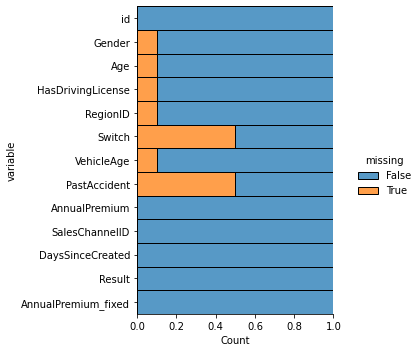

In [12]:
plt.figure(figsize=(20,6))
sns.displot(
    data=raw_df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1
)


In [13]:
raw_df.Result.value_counts()

0    267700
1     37187
Name: Result, dtype: int64

We see an imbalanced dataset but given we have quite a significant amount of data, we can try downsampling

### Exploratory Data Analysis

- Gender does not seem to play a role in whether someone is interested or not
- Has Driving License is a useless feature because almost everyone has one
- Switch is an important feature but I am not sure what it means - but if Switch is positive, no one is interested. However, a lot of that data is missing
- Age of Vehicle seems to play a role - the proportion of those who are interested is higher for those with >2 years than those who have a very new one (<1)
- Obviously those who had a past accident are more interested in the purchase
- Nothing too interesting in Region ID and Saleschannel ID, probably not too important
- Older people are more interested
- The mean for days since created is exactly the same so most likely not important but could create buckets and see whether there are any with a different trend
- It is the same for Annual premium


<AxesSubplot:xlabel='Switch', ylabel='count'>

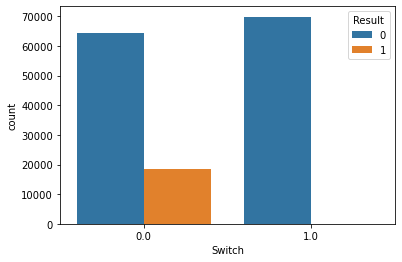

In [14]:
sns.countplot(x="Switch",hue="Result", data=raw_df)

<AxesSubplot:xlabel='HasDrivingLicense', ylabel='count'>

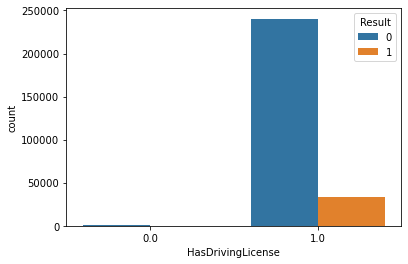

In [15]:
sns.countplot(x="HasDrivingLicense",hue="Result", data=raw_df)

<AxesSubplot:xlabel='Gender', ylabel='count'>

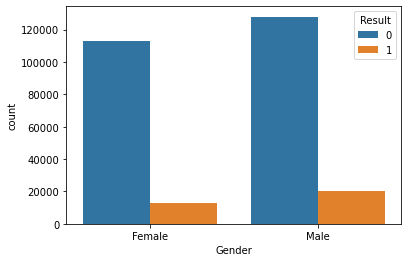

In [16]:
sns.countplot(x="Gender",hue="Result", data=raw_df)

<AxesSubplot:xlabel='VehicleAge', ylabel='count'>

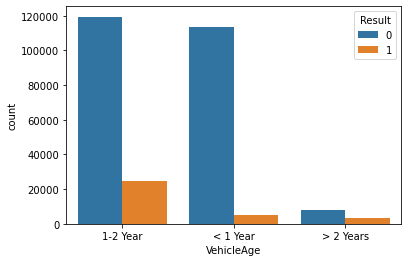

In [17]:
sns.countplot(x="VehicleAge",hue="Result", data=raw_df)

<AxesSubplot:xlabel='PastAccident', ylabel='count'>

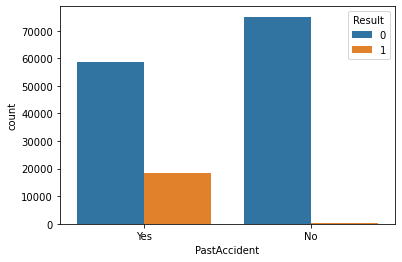

In [18]:
sns.countplot(x="PastAccident",hue="Result", data=raw_df)

<AxesSubplot:xlabel='RegionID', ylabel='count'>

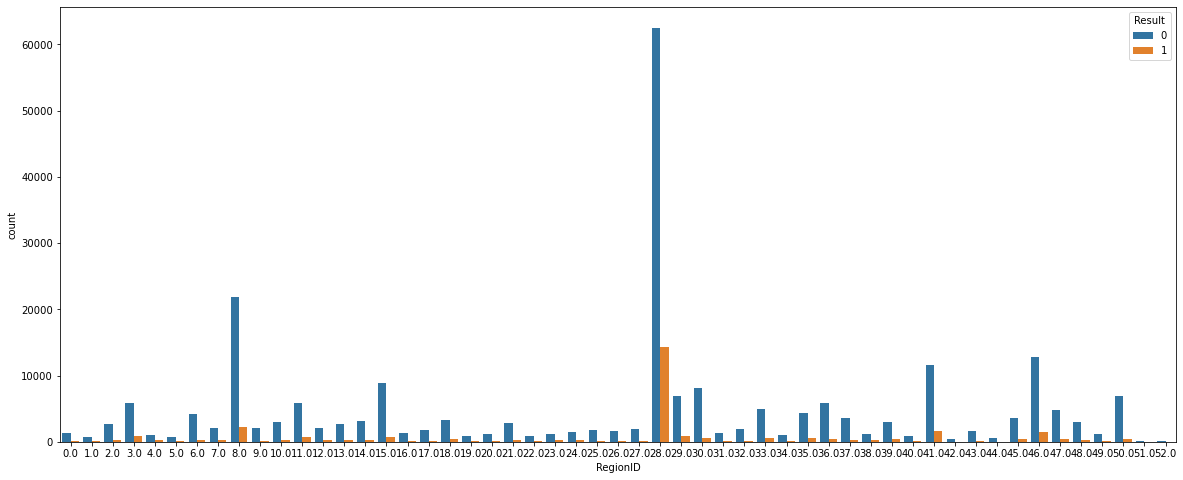

In [19]:
plt.figure(figsize=(20,8))
sns.countplot(x="RegionID",hue="Result", data=raw_df)

<AxesSubplot:xlabel='SalesChannelID', ylabel='count'>

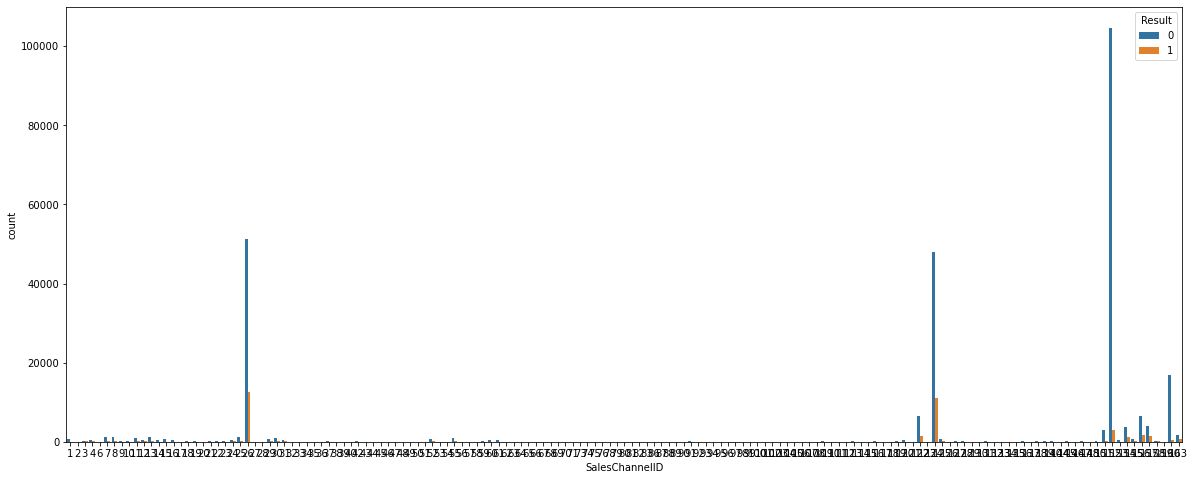

In [20]:
plt.figure(figsize=(20,8))

sns.countplot(x="SalesChannelID",hue="Result", data=raw_df)

The other variables are continuous so let's create some boxplots

<AxesSubplot:xlabel='Result', ylabel='Age'>

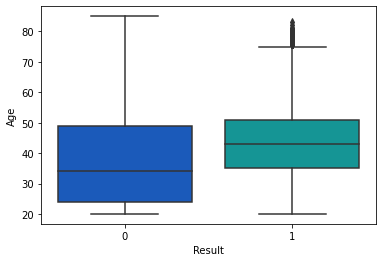

In [21]:
sns.boxplot(x='Result',y='Age',data=raw_df,palette='winter')

<AxesSubplot:xlabel='Result', ylabel='DaysSinceCreated'>

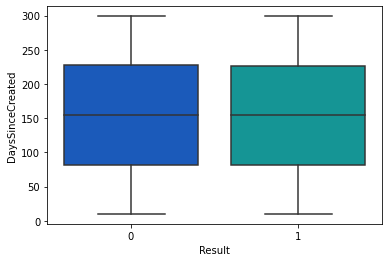

In [22]:
sns.boxplot(x='Result',y='DaysSinceCreated',data=raw_df,palette='winter')

<AxesSubplot:xlabel='Result', ylabel='AnnualPremium_fixed'>

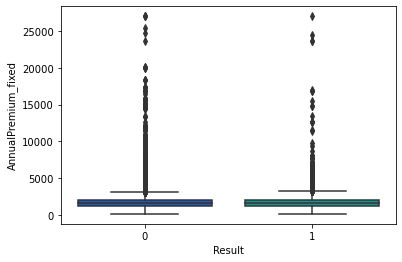

In [23]:
sns.boxplot(x='Result',y='AnnualPremium_fixed',data=raw_df,palette='winter')

In [24]:
raw_df['AgeGroup'] = pd.cut(raw_df['Age'],bins=[20, 30, 40, 50, 60, 70, 80, np.inf], labels=['20-30','30-40','40-50', '50-60','60-70', '70-80', '80+'])


<AxesSubplot:xlabel='AgeGroup', ylabel='count'>

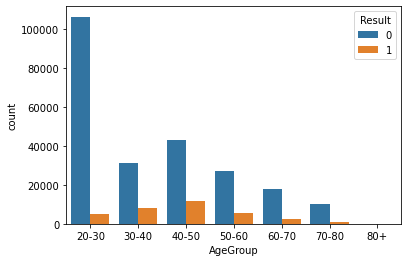

In [25]:
sns.countplot(x="AgeGroup",hue="Result", data=raw_df)

The dataset was highly imbalanced in regard to the target variable with only 12.2% interested in buying car insurance. Gender did not seem to play a significant.

Having a driving licence is a useless feature because only 0.2% of clients did not have a driving licence. The mean for the number of days since the current policy was created and the mean for the annual premium were the same for both groups, so most likely these features will not significantly contribute to model performance and do not have a lot of predictive power. 

The two most important features were past accidents and switch. We can see below that only those who did not switch were interested in car insurance, and almost everyone who had a past accident was interested.

### Handling missing values

We would loose 85% of our data if we simply dropped the missing values thus we need to impute them. However, out of curiousity, we can also use only 15% of the data and compare those models

In [26]:
print('Number of rows with nulls: {}'.format(raw_df.shape[0] - raw_df.dropna().shape[0]))
print('% of data lost if all null rows were dropped: {:2.2%}'.format(1 - (raw_df.dropna().shape[0] / raw_df.shape[0])))

Number of rows with nulls: 260510
% of data lost if all null rows were dropped: 85.44%


In [27]:
raw_df.columns

Index(['id', 'Gender', 'Age', 'HasDrivingLicense', 'RegionID', 'Switch',
       'VehicleAge', 'PastAccident', 'AnnualPremium', 'SalesChannelID',
       'DaysSinceCreated', 'Result', 'AnnualPremium_fixed', 'AgeGroup'],
      dtype='object')

In [28]:
X = raw_df[["Gender", "Age", "RegionID", "Switch", "VehicleAge", "PastAccident", "SalesChannelID", "DaysSinceCreated", "AnnualPremium_fixed"]]
y = raw_df[["Result"]]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40, stratify=y)

In [30]:
# Creating list of numeric and categorical features that need transforming
num_features = ["Age", "DaysSinceCreated",  "AnnualPremium_fixed"]
cat_features = ["Gender", "RegionID", "Switch", "VehicleAge", "PastAccident", "SalesChannelID"]

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer 

num_pipeline = Pipeline([
     ('std_scaler', StandardScaler()),
     ('knn_num_imputer', KNNImputer(n_neighbors = 10))
    
])


cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown = "ignore"))
    #('knn_num_imputer', KNNImputer(n_neighbors = 10))

])

In [32]:
from sklearn.compose import ColumnTransformer


full_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
])


X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared =  full_pipeline.transform(X_test)

#### Note: The code above takes a long time to run

## Baseline 1 (imputed values)

Setting a baseline on the test set so we can compare it with our final model. The test set is set aside until the very end. We will use cross validation on the training set to make design decisions. Another option is to split the training set again to have a validation set and use that one.

Given the imbalanced dataset we need to use the F1 Score to judge the performance, not accuracy.

In [33]:
#using SVM as baseline because Logistic Regression cant predict minority class at all (F1 score of 0)
svc = SVC(max_iter=3000)
svc.fit(X_train_prepared, y_train.values.ravel())

y_pred = svc.predict(X_test_prepared)


/Users/gleb.khamin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [34]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.897     0.836     0.865     53541
           1      0.206     0.307     0.247      7437

    accuracy                          0.772     60978
   macro avg      0.551     0.571     0.556     60978
weighted avg      0.813     0.772     0.790     60978



Baseline results: not ideal - model really struggles with the minority class so most likely we will need to resample our dataset first, before proceeding with feature selection, model selection and hyperparameter tuning.

### Resampling

In [35]:
from imblearn.under_sampling import RandomUnderSampler 

undersample = RandomUnderSampler(sampling_strategy='majority')

In [36]:
X_under, y_under = undersample.fit_resample(X, y)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size = 0.2, random_state = 40)

In [38]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared =  full_pipeline.transform(X_test)

## Baseline 2 (imputed values + undersampling)

In [39]:
svc.fit(X_train_prepared, y_train.values.ravel())

y_pred = svc.predict(X_test_prepared)
print(classification_report(y_test, y_pred, digits=3))

/Users/gleb.khamin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


              precision    recall  f1-score   support

           0      0.687     0.625     0.654      7359
           1      0.663     0.722     0.691      7516

    accuracy                          0.674     14875
   macro avg      0.675     0.673     0.673     14875
weighted avg      0.675     0.674     0.673     14875



This is significantly better now - let's, out of curiosity, also try two other sampling methods. Note, the code will run for quite a while given we are generating more data.

In [40]:
from imblearn.over_sampling import RandomOverSampler 
oversample = RandomOverSampler(sampling_strategy='minority')

X_over, y_over = oversample.fit_resample(X, y)


In [41]:
# to avoud frying my computer I will only sample 100k
X_over["Result"] = y_over

In [42]:
sample = X_over.sample(100000)

In [43]:
y_over = sample.Result
X_over = sample.drop("Result", axis=1)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.2, random_state = 40)

X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared =  full_pipeline.transform(X_test)

## Baseline 3 (imputed values + oversampling)

The results are very similar to understampling.

In [45]:
svc.fit(X_train_prepared, y_train.values.ravel())

y_pred = svc.predict(X_test_prepared)
print(classification_report(y_test, y_pred, digits=3))

/Users/gleb.khamin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


              precision    recall  f1-score   support

           0      0.655     0.607     0.630     10036
           1      0.631     0.678     0.654      9964

    accuracy                          0.643     20000
   macro avg      0.643     0.643     0.642     20000
weighted avg      0.643     0.643     0.642     20000



#### SMOTE

SMOTE requires some preprocessing of the data because it does not like NAN and categorical data needs to be encoded.

In [46]:
from imblearn.over_sampling import SMOTE

In [47]:
#SMOTE expects encoded labels and doesnt accept NANs

le = LabelEncoder()
X["Gender_en"] = le.fit_transform(X["Gender"])
X["reg_en"] = le.fit_transform(X["RegionID"])
X["switch_en"] = le.fit_transform(X["Switch"])
X["vage_en"] = le.fit_transform(X["VehicleAge"])
X["acc_en"] = le.fit_transform(X["PastAccident"])
X["sales_en"] = le.fit_transform(X["SalesChannelID"])

/var/folders/sk/4xszcryd1ygcbjn1fj1jbj940000gn/T/ipykernel_54955/3531025657.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Gender_en"] = le.fit_transform(X["Gender"])
/var/folders/sk/4xszcryd1ygcbjn1fj1jbj940000gn/T/ipykernel_54955/3531025657.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["reg_en"] = le.fit_transform(X["RegionID"])
/var/folders/sk/4xszcryd1ygcbjn1fj1jbj940000gn/T/ipykernel_54955/3531025657.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [48]:
X_en = X[["Gender_en", "reg_en", "switch_en", "vage_en", "acc_en", "sales_en", "Age", "AnnualPremium_fixed", "DaysSinceCreated"]]
X = X[["Gender", "Age", "RegionID", "Switch", "VehicleAge" ,"PastAccident", "SalesChannelID" ,"DaysSinceCreated", "AnnualPremium_fixed"]]


In [49]:
cat_features_SMOTE = ["Gender_en", "reg_en", "switch_en", "vage_en", "acc_en", "sales_en"]

In [50]:
num_pipeline = Pipeline([
     ('std_scaler', StandardScaler()),
     ('knn_num_imputer', KNNImputer(n_neighbors = 10))
    
])


cat_pipeline_SMOTE = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown = "use_encoded_value",unknown_value=-1))
    #('knn_num_imputer', KNNImputer(n_neighbors = 10))

])

In [51]:
full_pipeline_SMOTE = ColumnTransformer([
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline_SMOTE, cat_features_SMOTE)
])


In [52]:
X_en_prepared = full_pipeline_SMOTE.fit_transform(X_en)


In [53]:
len(X_en_prepared)

304887

In [54]:
oversample = SMOTE()
X_SMOTE, y_SMOTE = oversample.fit_resample(X_en_prepared, y)

In [55]:
y_SMOTE_np = np.asarray(y_SMOTE.Result.tolist())

In [56]:
idx = np.random.choice(np.arange(len(X_SMOTE)), 100000, replace=False)
y_SMOTE = y_SMOTE_np[idx]
X_SMOTE = X_SMOTE[idx]

In [57]:

X_train, X_test, y_train, y_test = train_test_split(X_SMOTE, y_SMOTE, test_size = 0.2, random_state = 40)


## Baseline 3 (imputed Data + SMOTE)

SMOTE for some reason worked really bad so we will continue with undersampling given its the least amount of data.

In [58]:
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)


/Users/gleb.khamin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [59]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.560     0.748     0.641     10012
           1      0.619     0.410     0.494      9988

    accuracy                          0.580     20000
   macro avg      0.590     0.579     0.567     20000
weighted avg      0.590     0.580     0.567     20000



## Baseline 4 (delete all NANs and work with the remaining 15% of data + undersample)

Given that we impute a lot of data which could be wrong, let's only keep those observations where we have all data

In [60]:
raw_df_na = raw_df.dropna()

In [61]:
len(raw_df_na)

44377

In [62]:
raw_df_na.Result.value_counts()

0    38935
1     5442
Name: Result, dtype: int64

In [63]:
X_na = raw_df_na[["Gender", "Age", "RegionID", "Switch", "VehicleAge", "PastAccident", "SalesChannelID", "DaysSinceCreated", "AnnualPremium_fixed"]]
y_na = raw_df_na[["Result"]]

In [64]:
X_under_na, y_under_na = undersample.fit_resample(X_na, y_na)
X_train, X_test, y_train, y_test = train_test_split(X_under_na, y_under_na, test_size = 0.2, random_state = 40)
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared =  full_pipeline.transform(X_test)

svc.fit(X_train_prepared, y_train.values.ravel())

y_pred = svc.predict(X_test_prepared)
print(classification_report(y_test, y_pred, digits=3))

/Users/gleb.khamin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


              precision    recall  f1-score   support

           0      0.934     0.636     0.757      1072
           1      0.730     0.957     0.828      1105

    accuracy                          0.799      2177
   macro avg      0.832     0.796     0.793      2177
weighted avg      0.831     0.799     0.793      2177



### Great! 

This is significantly better. Even though we have lost so much data. We will see later WHY that is the case. For now I will proceed with approach (1) imputing and undersampling, but later we will go back to this approach

In [65]:


X_under, y_under = undersample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size = 0.2, random_state = 40)

## Cross validation

Let's see how the SVM performs on the training set using cross validation - we will use this method now to make all design decisions.

In [66]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

In [67]:
pipeline = make_pipeline(full_pipeline,svc)

In [68]:
scores = cross_val_score(pipeline, X_train, y_train.values.ravel(), cv=5, scoring="f1_weighted")

/Users/gleb.khamin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/gleb.khamin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/gleb.khamin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/gleb.khamin/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/gleb.khamin/opt/anaconda3/lib/python3.9/site-

In [69]:
scores.mean()

0.6401101792079882

## Model Selection

Before we drop any features let's test a few models. We will use
- KNN
- SVC
- Decision Tree
- MLP
- Logistic Regression

Then we will proceed with the top 3 performing models based on scikit learns default parameters


If we had more time, I would use XGBoost (due to its power potential), however I am limited on time.


In [70]:

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [71]:
#for now using default parameters
knn = KNeighborsClassifier()
dt = tree.DecisionTreeClassifier(max_depth=10) #to avoid overfitting
mlp = MLPClassifier(early_stopping=True, hidden_layer_sizes=(10,1))
lr = LogisticRegression(max_iter=1000)

In [72]:
rf = RandomForestClassifier()
ab = AdaBoostClassifier()

In [73]:
#knn
pipeline = make_pipeline(full_pipeline,knn)
scores = cross_val_score(pipeline, X_train, y_train.values.ravel(), cv=5, scoring="f1_weighted")
scores.mean()

0.716613315497318

In [74]:
#tree
pipeline = make_pipeline(full_pipeline,dt)
scores = cross_val_score(pipeline, X_train, y_train.values.ravel(), cv=5, scoring="f1_weighted")
scores.mean()

0.7532287383794476

In [75]:
#mlp
pipeline = make_pipeline(full_pipeline,mlp)
scores = cross_val_score(pipeline, X_train, y_train.values.ravel(), cv=5, scoring="f1_weighted")
scores.mean()

0.6710068726335662

In [76]:
#lr
pipeline = make_pipeline(full_pipeline,lr)
scores = cross_val_score(pipeline, X_train, y_train.values.ravel(), cv=5, scoring="f1_weighted")
scores.mean()

0.7559791620258434

In [ ]:
#rf
pipeline = make_pipeline(full_pipeline,rf)
scores = cross_val_score(pipeline, X_train, y_train.values.ravel(), cv=5, scoring="f1_weighted")
scores.mean()

In [ ]:
#ab
pipeline = make_pipeline(full_pipeline,ab)
scores = cross_val_score(pipeline, X_train, y_train.values.ravel(), cv=5, scoring="f1_weighted")
scores.mean()

Ok, we can see that all models perform better than our SVC baseline but that most of the models show very similar performance.

To cover several different models we will proceed with
- linear method (logistic regression)
- tree based method (decision tree)
- ensemble method (adaboost - which is interesting to see whether it will be better than the simple tree based method given the base estimator is a decitiontree classifier with an initialised max depth of 1)

## Feature Selection

https://scikit-learn.org/stable/modules/feature_selection.html

There are several ways of doing this. Using statistical tests or ML

We will do hybrid approach  -  delete those we earlier identified as most likely useless. see how model performs. Then, on the remaining ones we can check out some of the automated methods. But given we dont have that many features we can do it manually first

In [ ]:
X_train

In [ ]:
# lets get rid of Gender given we saw that most likely it doesnt carry any value
# lets play around with region and saleschannel given the many classes which makes it hard to see it on the plots


#lets get rid of days since created given mean exactly the same in both groups
# lets play around with annual premium given mean also same in both groups

X_train_feat1 = X_train[["SalesChannelID","Age", "VehicleAge", "Switch", "PastAccident"]]

In [ ]:
full_pipeline_feat1 = ColumnTransformer([
        ('num', num_pipeline, ["Age"]),
        ('cat', cat_pipeline, ["SalesChannelID", "Switch", "VehicleAge","PastAccident"])
])


In [ ]:
pipeline_feat1 = make_pipeline(full_pipeline_feat1,lr)
scores = cross_val_score(pipeline_feat1, X_train_feat1, y_train.values.ravel(), cv=5, scoring="f1_weighted")
scores.mean()

verifying features also work with the other two classifiers

In [ ]:
#decision tree
pipeline_feat1 = make_pipeline(full_pipeline_feat1,dt)
scores = cross_val_score(pipeline_feat1, X_train_feat1, y_train.values.ravel(), cv=5, scoring="f1_weighted")
scores.mean()

In [ ]:
#adaboost
pipeline_feat1 = make_pipeline(full_pipeline_feat1,ab)
scores = cross_val_score(pipeline_feat1, X_train_feat1, y_train.values.ravel(), cv=5, scoring="f1_weighted")
scores.mean()

### Observations using logistic regression
- Gender: no difference -> F1 score remains at 0.755 as we predicted
- Region: no differen -> F1 score remains at 0.755 
- Saleschannel: adds value! deleting it causes a drop of 0.025 to 0.73
- days since created: no difference -> F1 score remains at 0.755 
- annual premium:  no difference -> F1 score remains at 0.755 

My assumption is now that all the other features are useful but this can easily be tested by deleting the columns from the data and analyse performance

- Age: Interestingly does not add much value - F1 score drops to only 0.753 which is surprising given that younger people (20-30 year old) are much less interested. But we will keep the feature given the slight reduction in performance. However, given we deleted all numerical features, we could consider changing the standardisation method and just scale
- Vehicle Age:  Interestingly also does not add much value - F1 score drops to only 0.75. But we will keep the feature given the slight reduction in performance. 


- Switch: adds value! deleting it causes a drop of 0.025 to 0.73
- Past Accident: adds value! deleting it causes a drop of 0.026 to 0.729


Only keeping best features: SalesChannel, Switch & Past Accident: 0.753
With Age and Vehicle Age: 0.755

## Hyperparameter tuning of 3 chosen models

In [ ]:
X_tr = full_pipeline_feat1.fit_transform(X_train_feat1)

In [ ]:
from sklearn.model_selection import GridSearchCV


#LR
parameters = {'C': np.linspace(0.1, 2, 10),"solver":["newton-cg", "lbfgs", "sag", "liblinear", "saga"]}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), parameters)
grid_search.fit(X_tr, y_train.values.ravel())

print('best parameters: ', grid_search.best_params_)
print('best scores: ', grid_search.best_score_)

It is not surprising it suggests a strong regularisation given the data most likely doesnt reflect the real world given how much data was imputed and hence might be wrong.

In [ ]:
pipeline_feat1 = make_pipeline(full_pipeline_feat1,LogisticRegression(max_iter=3000,C=0.1, solver="newton-cg"))
scores = cross_val_score(pipeline_feat1, X_train_feat1, y_train.values.ravel(), cv=5, scoring="f1_weighted")
scores.mean()

But when using these parameters the results do not really improve and remain at the previous 0.755

In [ ]:
#dt
parameters = {'max_depth': [5,10,15,20,25],"criterion":["gini", "entropy", "log_loss"]}
grid_search = GridSearchCV(tree.DecisionTreeClassifier(), parameters)
grid_search.fit(X_tr, y_train.values.ravel())

print('best parameters: ', grid_search.best_params_)
print('best scores: ', grid_search.best_score_)

In [ ]:
pipeline_feat1 = make_pipeline(full_pipeline_feat1,tree.DecisionTreeClassifier(criterion="entropy", max_depth=10))
scores = cross_val_score(pipeline_feat1, X_train_feat1, y_train.values.ravel(), cv=5, scoring="f1_weighted")
scores.mean()

There is no real difference between Gini and entropy.

In [ ]:
#AB

parameters = {'n_estimators': [50, 75,100,125,150],"algorithm":["SAMME","SAMME.R"]}
grid_search = GridSearchCV(AdaBoostClassifier(), parameters)
grid_search.fit(X_tr, y_train.values.ravel())

print('best parameters: ', grid_search.best_params_)
print('best scores: ', grid_search.best_score_)

In [ ]:
pipeline_feat1 = make_pipeline(full_pipeline_feat1,AdaBoostClassifier(n_estimators=150))
scores = cross_val_score(pipeline_feat1, X_train_feat1, y_train.values.ravel(), cv=5, scoring="f1_weighted")
scores.mean()

## Test time

In [ ]:
X_test_feat1 = X_test[["SalesChannelID","Age", "VehicleAge", "Switch", "PastAccident"]]

In [ ]:
lr = LogisticRegression(max_iter=3000,C=0.1, solver="newton-cg")
X_train_prepared = full_pipeline_feat1.fit_transform(X_train_feat1)
X_test_prepared =  full_pipeline_feat1.transform(X_test_feat1)
lr.fit(X_train_prepared, y_train.values.ravel())

y_pred = lr.predict(X_test_prepared)
print(classification_report(y_test, y_pred, digits=3))

In [ ]:
lr = AdaBoostClassifier(n_estimators=150)
X_train_prepared = full_pipeline_feat1.fit_transform(X_train_feat1)
X_test_prepared =  full_pipeline_feat1.transform(X_test_feat1)
lr.fit(X_train_prepared, y_train.values.ravel())

y_pred = lr.predict(X_test_prepared)
print(classification_report(y_test, y_pred, digits=3))

In [ ]:
lr = tree.DecisionTreeClassifier(criterion="entropy", max_depth=10)
X_train_prepared = full_pipeline_feat1.fit_transform(X_train_feat1)
X_test_prepared =  full_pipeline_feat1.transform(X_test_feat1)
lr.fit(X_train_prepared, y_train.values.ravel())

y_pred = lr.predict(X_test_prepared)
print(classification_report(y_test, y_pred, digits=3))

## Preliminary result

We got similar performance on our test set as during cross validation (around 0.755 F1) with Adaboost performing slightly better than the rest. However, we saw earlier that by keeping only those observations where we have ALL data, we can achieve higher performance. This is not surprising given 2 of the 3 most valuable feature are Switch and Past Accident, where almost half of the data is missing. Now that we know wich 5 features we need to build our model, let's select only those columns and drop the NAN. this way we should retain more data.

We will only use Adaboost given it performed the best and tune hyperparameters for the new dataset.


In [ ]:
X

In [ ]:
X = X[["SalesChannelID","Age", "VehicleAge", "Switch", "PastAccident"]]

In [ ]:
X

In [ ]:
print('Number of rows with nulls: {}'.format(X.shape[0] - X.dropna().shape[0]))
print('% of data lost if all null rows were dropped: {:2.2%}'.format(1 - (X.dropna().shape[0] / X.shape[0])))

In [ ]:
X["Result"] = y

In [ ]:
X.dropna(inplace=True)

In [ ]:
X_new = X[["SalesChannelID","Age", "VehicleAge", "Switch", "PastAccident"]]
y_new = X[["Result"]]

In [ ]:
X.Result.value_counts()

In [ ]:

X_under, y_under = undersample.fit_resample(X_new, y_new)
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size = 0.15, random_state = 40)

In [ ]:
ab =AdaBoostClassifier()
pipeline = make_pipeline(full_pipeline_feat1,ab)
scores = cross_val_score(pipeline, X_train, y_train.values.ravel(), cv=5, scoring="f1_weighted")
scores.mean()

In [ ]:
X_tr = full_pipeline_feat1.fit_transform(X_train)

parameters = {'n_estimators': [50, 75,100,125,150],"algorithm":["SAMME","SAMME.R"]}
grid_search = GridSearchCV(AdaBoostClassifier(), parameters)
grid_search.fit(X_tr, y_train.values.ravel())

print('best parameters: ', grid_search.best_params_)
print('best scores: ', grid_search.best_score_)

In [ ]:
ab =AdaBoostClassifier(n_estimators=100, algorithm="SAMME")
pipeline = make_pipeline(full_pipeline_feat1,ab)
scores = cross_val_score(pipeline, X_train, y_train.values.ravel(), cv=5, scoring="f1_weighted")
scores.mean()

In [ ]:
X_train_prepared = full_pipeline_feat1.fit_transform(X_train)
X_test_prepared =  full_pipeline_feat1.transform(X_test)
ab.fit(X_train_prepared, y_train.values.ravel())

y_pred = ab.predict(X_test_prepared)
print(classification_report(y_test, y_pred, digits=3))

In [ ]:
just_for_fun =  full_pipeline_feat1.transform(X_new)

## Final Result

By dropping all NAN and not imputing them and using only a small balanced dataset of 15k observations we can significantly increase the performance of our baseline model which had a macro F1 score of only 0.570. The reason being (1) the imbalance and (2) that the 2 main predictors contain most of the missing values.

However, the problem for the future remains: the new data that the trained model would be used on, will most likely also be imbalanced and it is questionable how well the model, which was trained on balanced data, would perform on real world data.


### Future work
One could try to build a classifies for the two features, although it is questionable how good they would be. One might infer by Age and Vehicle age the probability of having had an accident in the past, but Switch is most likely not predictable given the information we have.